In [1]:
#Packages ####
library(readr)
library(tidyverse)
library(psych)
library(corrplot)
library(imputeTS)
library(ggfortify) #PCA plot biplot
library(MASS)
library(klaR) # LDA Plot
library(dbscan) #ClusterAnalysis 


## Running code

a = "../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv"
AB = read_csv(a)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   1.0.0          ✔ stringr 1.4.0     
✔ ggplot2 3.2.1.9000     ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


corrplot 0.84 loaded

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff

Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot

In [2]:
AB = as.data.frame(AB)
ddd <-  c("id", "host_id")
AB[ddd] <- NULL

#Character columns to factor columns 
names_to_factor <- c("host_name", "neighbourhood_group", "neighbourhood", "room_type")
AB[names_to_factor] <- map(AB[names_to_factor], as.factor)

#Convert to date format
AB[c("last_review")] <- AB[c("last_review")] %>% map(~lubridate::ymd(.x))
#Check
glimpse(AB)

Observations: 48,895
Variables: 14
$ name                           <chr> "Clean & quiet apt home by the park", …
$ host_name                      <fct> John, Jennifer, Elisabeth, LisaRoxanne…
$ neighbourhood_group            <fct> Brooklyn, Manhattan, Manhattan, Brookl…
$ neighbourhood                  <fct> Kensington, Midtown, Harlem, Clinton H…
$ latitude                       <dbl> 40.64749, 40.75362, 40.80902, 40.68514…
$ longitude                      <dbl> -73.97237, -73.98377, -73.94190, -73.9…
$ room_type                      <fct> Private room, Entire home/apt, Private…
$ price                          <dbl> 149, 225, 150, 89, 80, 200, 60, 79, 79…
$ minimum_nights                 <dbl> 1, 1, 3, 1, 10, 3, 45, 2, 2, 1, 5, 2, …
$ number_of_reviews              <dbl> 9, 45, 0, 270, 9, 74, 49, 430, 118, 16…
$ last_review                    <date> 2018-10-19, 2019-05-21, NA, 2019-07-0…
$ reviews_per_month              <dbl> 0.21, 0.38, NA, 4.64, 0.10, 0.59, 0.40…
$ calculated_host

In [3]:
#Missing Data
Missing <- AB %>% summarise_all(~(sum(is.na(.))/n()))
Missing <- gather(Missing, key = "variables", value = "percent_missing")
AB$reviews_per_month = na_mean(AB$reviews_per_month)
Missing

variables,percent_missing
<chr>,<dbl>
name,0.0003272318
host_name,0.0004294918
neighbourhood_group,0.0000000000
neighbourhood,0.0000000000
latitude,0.0000000000
longitude,0.0000000000
room_type,0.0000000000
price,0.0000000000
minimum_nights,0.0000000000


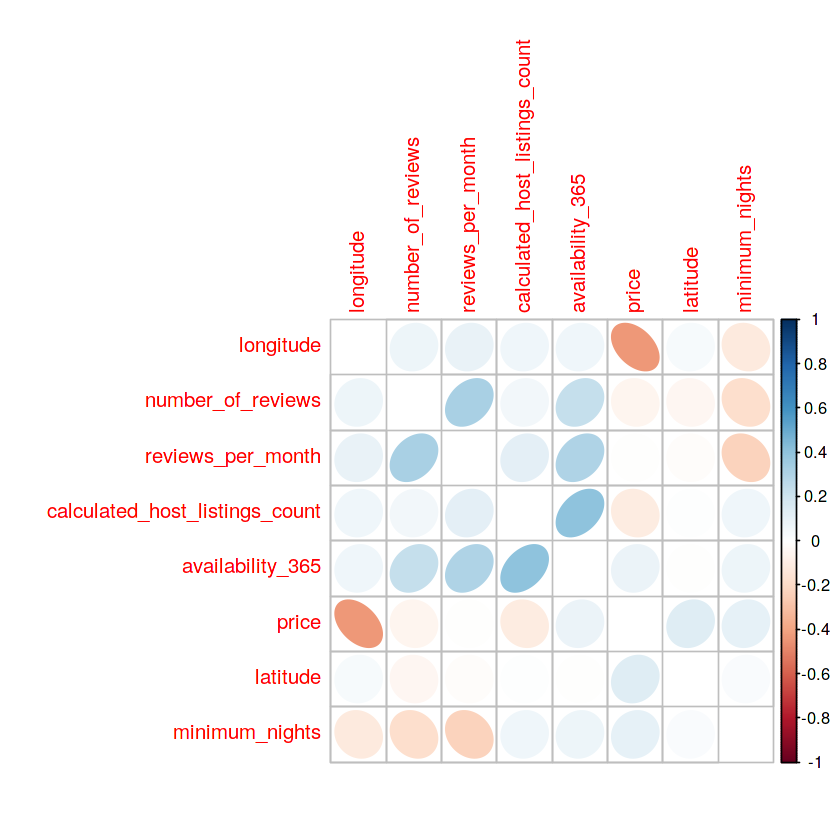

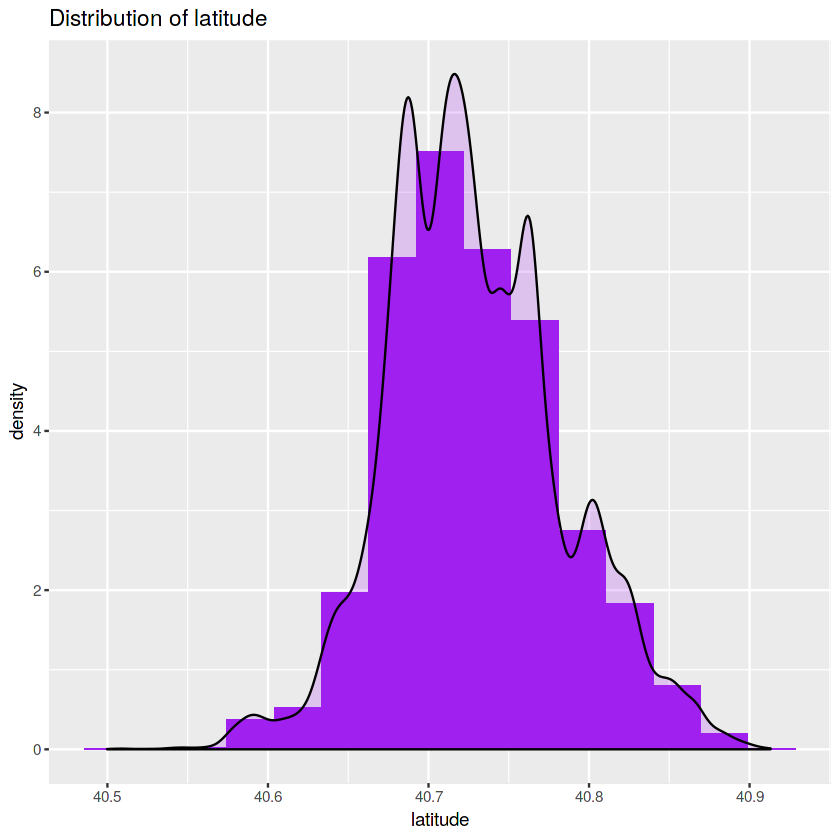

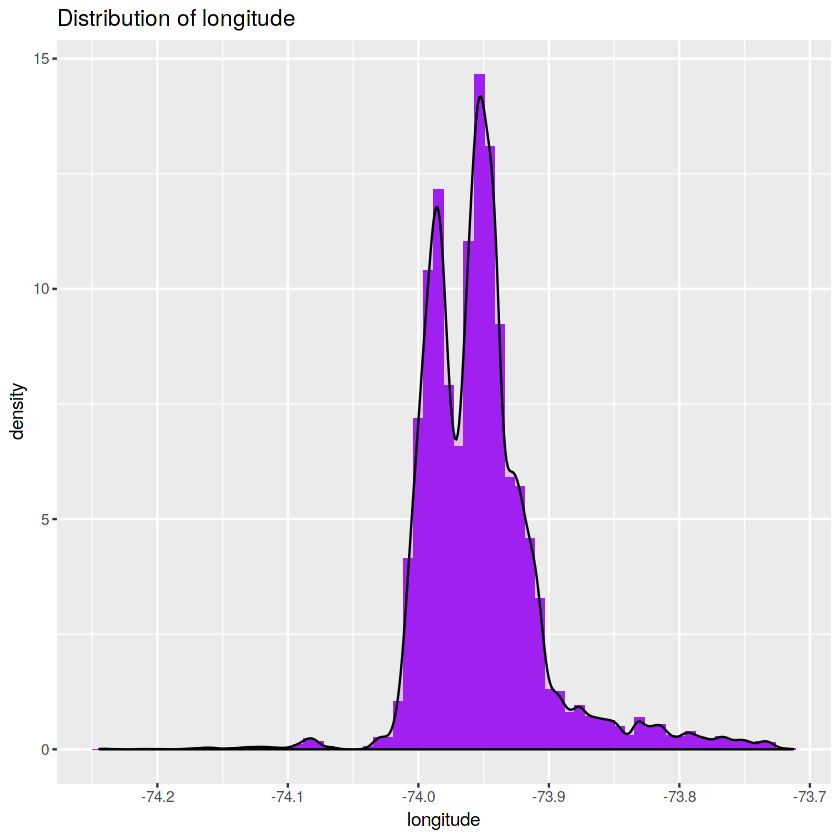

'data.frame':	48895 obs. of  8 variables:
 $ latitude                      : num  40.6 40.8 40.8 40.7 40.8 ...
 $ longitude                     : num  -74 -74 -73.9 -74 -73.9 ...
 $ price                         : num  149 225 150 89 80 200 60 79 79 150 ...
 $ minimum_nights                : num  1 1 3 1 10 3 45 2 2 1 ...
 $ number_of_reviews             : num  9 45 0 270 9 74 49 430 118 160 ...
 $ reviews_per_month             : num  0.21 0.38 1.37 4.64 0.1 ...
 $ calculated_host_listings_count: num  6 2 1 1 1 1 1 1 1 4 ...
 $ availability_365              : num  365 355 365 194 0 129 0 220 0 188 ...
 - attr(*, "spec")=
  .. cols(
  ..   id = col_double(),
  ..   name = col_character(),
  ..   host_id = col_double(),
  ..   host_name = col_character(),
  ..   neighbourhood_group = col_character(),
  ..   neighbourhood = col_character(),
  ..   latitude = col_double(),
  ..   longitude = col_double(),
  ..   room_type = col_character(),
  ..   price = col_double(),
  ..   minimum_night

    latitude       longitude          price         minimum_nights   
 Min.   :40.50   Min.   :-74.24   Min.   :    0.0   Min.   :   1.00  
 1st Qu.:40.69   1st Qu.:-73.98   1st Qu.:   69.0   1st Qu.:   1.00  
 Median :40.72   Median :-73.96   Median :  106.0   Median :   3.00  
 Mean   :40.73   Mean   :-73.95   Mean   :  152.7   Mean   :   7.03  
 3rd Qu.:40.76   3rd Qu.:-73.94   3rd Qu.:  175.0   3rd Qu.:   5.00  
 Max.   :40.91   Max.   :-73.71   Max.   :10000.0   Max.   :1250.00  
 number_of_reviews reviews_per_month calculated_host_listings_count
 Min.   :  0.00    Min.   : 0.010    Min.   :  1.000               
 1st Qu.:  1.00    1st Qu.: 0.280    1st Qu.:  1.000               
 Median :  5.00    Median : 1.220    Median :  1.000               
 Mean   : 23.27    Mean   : 1.373    Mean   :  7.144               
 3rd Qu.: 24.00    3rd Qu.: 1.580    3rd Qu.:  2.000               
 Max.   :629.00    Max.   :58.500    Max.   :327.000               
 availability_365
 Min.   :  0.0  

Principal Components Analysis
Call: principal(r = ABC, nfactors = 4, covar = TRUE)
Unstandardized loadings (pattern matrix) based upon covariance matrix
                                  RC1    RC2   RC3    RC4      h2      u2
latitude                         0.00   0.00  0.00   0.00 5.7e-06 3.0e-03
longitude                       -0.01   0.00  0.00   0.00 1.1e-04 2.0e-03
price                          233.21  47.27  8.27 -31.34 5.8e+04 9.8e-04
minimum_nights                   0.77   3.15 -1.80   3.23 2.4e+01 4.0e+02
number_of_reviews               -4.14  -0.32 44.22  -3.26 2.0e+03 1.1e+00
reviews_per_month               -0.09   0.10  0.79  -0.03 6.5e-01 1.6e+00
calculated_host_listings_count   5.35   4.43  0.54  32.16 1.1e+03 3.0e+00
availability_365               -13.70 127.93 23.54  14.68 1.7e+04 1.7e-01
                                   H2      U2
latitude                       0.0019 1.0e+00
longitude                      0.0499 9.5e-01
price                          1.0000 1.7e-

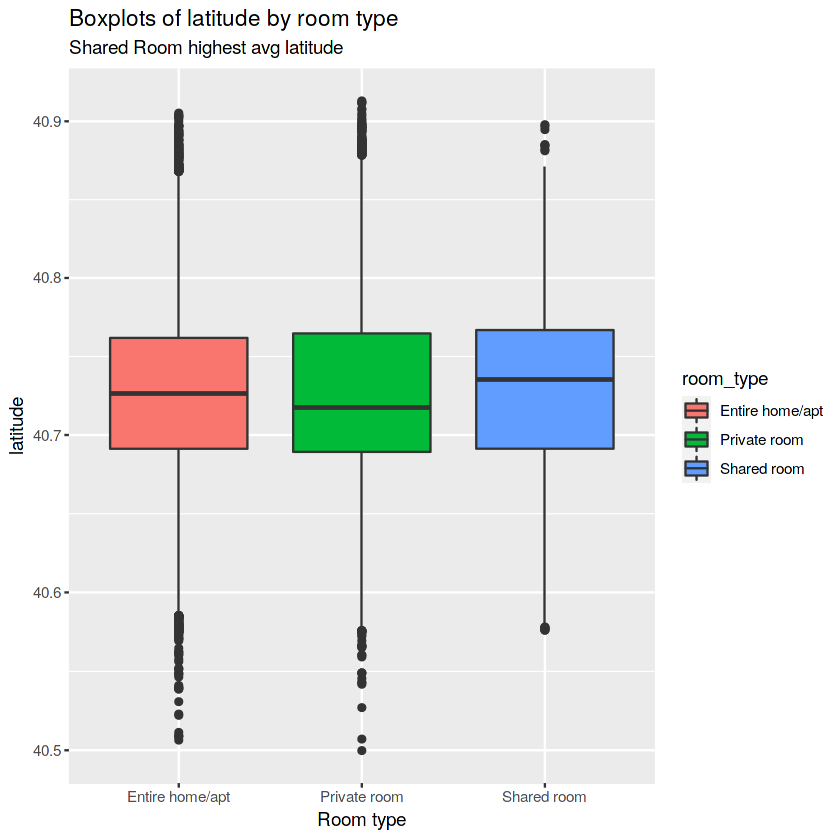

In [4]:
#Numeric
ABC <- AB %>% select_if(is.numeric)
ABC[ddd] <- NULL

#Data Vis ####
a_cor <- ABC[complete.cases(ABC), ]
cor_a <- cor(a_cor, method = 'spearman') 
corrplot(cor_a, method = 'ellipse', order = "AOE", diag = FALSE)

#Histogram Latitude
ggplot(AB, aes(latitude)) +
  geom_histogram(bins = 15, aes(y = ..density..), fill = "purple") + 
  geom_density(alpha = 0.2, fill = "purple") +
  ggtitle("Distribution of latitude") +
  theme(axis.title = element_text(), axis.title.x = element_text())

#Histogram longitude  
ggplot(AB, aes(longitude)) +
    geom_histogram(bins = 70, aes(y = ..density..), fill = "purple") + 
    geom_density(alpha = 0.2, fill = "purple") +
    ggtitle("Distribution of longitude") +
theme(axis.title = element_text(), axis.title.x = element_text())

#Boxplot Latitude
ggplot(AB, aes(x = room_type, y = latitude)) +
  geom_boxplot(aes(fill = room_type)) + scale_y_log10() +
  xlab("Room type") + 
  ylab("latitude") +
  ggtitle("Boxplots of latitude by room type",
        subtitle = "Shared Room highest avg latitude") 


#Variable Selction ####  
str(ABC)
summary(ABC)

#PCA with Numerical variables only
P_A <- principal(ABC, nfactors = 4, covar = TRUE)
print(P_A)

print(P_A$loadings, cutoff=.25)

Warning message in arrows(0, 0, loadings[, 1L] * 0.8, loadings[, 2L] * 0.8, col = col[2L], :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, loadings[, 1L] * 0.8, loadings[, 2L] * 0.8, col = col[2L], :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, loadings[, 1L] * 0.8, loadings[, 2L] * 0.8, col = col[2L], :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, loadings[, 1L] * 0.8, loadings[, 2L] * 0.8, col = col[2L], :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, loadings[, 1L] * 0.8, loadings[, 2L] * 0.8, col = col[2L], :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, loadings[, 1L] * 0.8, loadings[, 2L] * 0.8, col = col[2L], :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, loadings[, 1L] * 0.8, loadings[, 2L] * 0.8, 

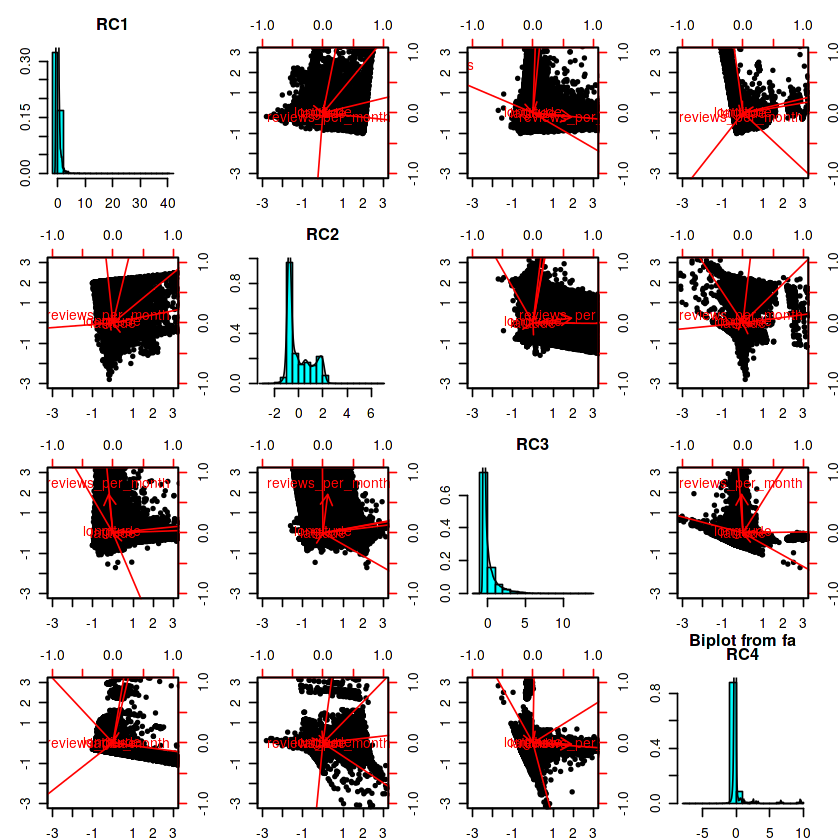

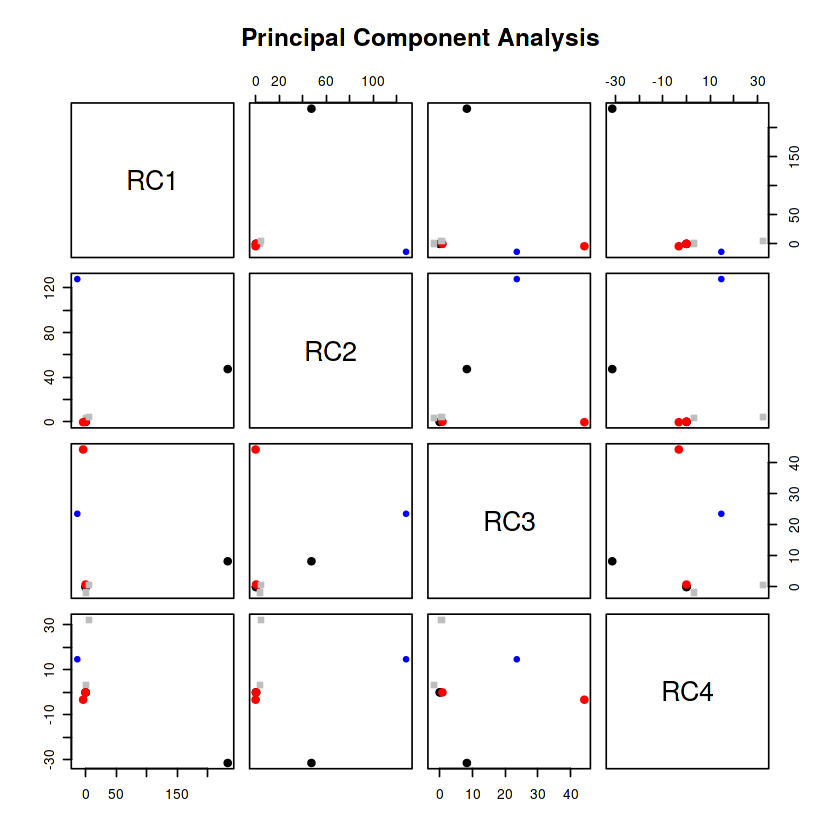

In [5]:
#PCA Cor- Plot Analysis

biplot.psych(P_A)

plot.psych(P_A)


In [6]:
#LDA by Room Type
AB <- as.data.frame(AB)
LDA_A <- lda(AB$room_type ~ AB$latitude + AB$longitude + AB$price + AB$availability_365
             , data = AB)
print(LDA_A)

#LDA by Neighborhood group
LDA_B <- lda(AB$neighbourhood_group ~ AB$longitude + AB$latitude + AB$room_type + AB$price + AB$minimum_nights 
             + AB$availability_365, data = AB,  factors = 2)
print(LDA_B)

Call:
lda(AB$room_type ~ AB$latitude + AB$longitude + AB$price + AB$availability_365, 
    data = AB)

Prior probabilities of groups:
Entire home/apt    Private room     Shared room 
     0.51966459      0.45661111      0.02372431 

Group means:
                AB$latitude AB$longitude  AB$price AB$availability_365
Entire home/apt    40.72865    -73.96070 211.79425            111.9203
Private room       40.72921    -73.94292  89.78097            111.2039
Shared room        40.73051    -73.94334  70.12759            162.0009

Coefficients of linear discriminants:
                              LD1           LD2
AB$latitude         -5.008926e-02 -1.7356976277
AB$longitude        -1.177314e+01  5.7063131937
AB$price             3.407018e-03  0.0006658201
AB$availability_365 -4.088015e-04 -0.0075556993

Proportion of trace:
   LD1    LD2 
0.9645 0.0355 
Call:
lda(AB$neighbourhood_group ~ AB$longitude + AB$latitude + AB$room_type + 
    AB$price + AB$minimum_nights + AB$availability_365, dat

In [7]:
#LDA by Neighborhood group
LDA_B <- lda(AB$neighbourhood_group ~ AB$longitude + AB$latitude + AB$room_type + AB$price + AB$minimum_nights 
             + AB$availability_365, data = AB)
print(LDA_B)
help(predict.lda)

Call:
lda(AB$neighbourhood_group ~ AB$longitude + AB$latitude + AB$room_type + 
    AB$price + AB$minimum_nights + AB$availability_365, data = AB)

Prior probabilities of groups:
        Bronx      Brooklyn     Manhattan        Queens Staten Island 
  0.022313120   0.411166786   0.443010533   0.115880969   0.007628592 

Group means:
              AB$longitude AB$latitude AB$room_typePrivate room
Bronx            -73.88455    40.84830                0.5976169
Brooklyn         -73.95119    40.68504                0.5039793
Manhattan        -73.97461    40.76506                0.3684964
Queens           -73.87277    40.73153                0.5951288
Staten Island    -74.10581    40.61022                0.5040214
              AB$room_typeShared room  AB$price AB$minimum_nights
Bronx                      0.05499542  87.49679          4.560953
Brooklyn                   0.02054318 124.38321          6.056556
Manhattan                  0.02215964 196.87581          8.579151
Queens           

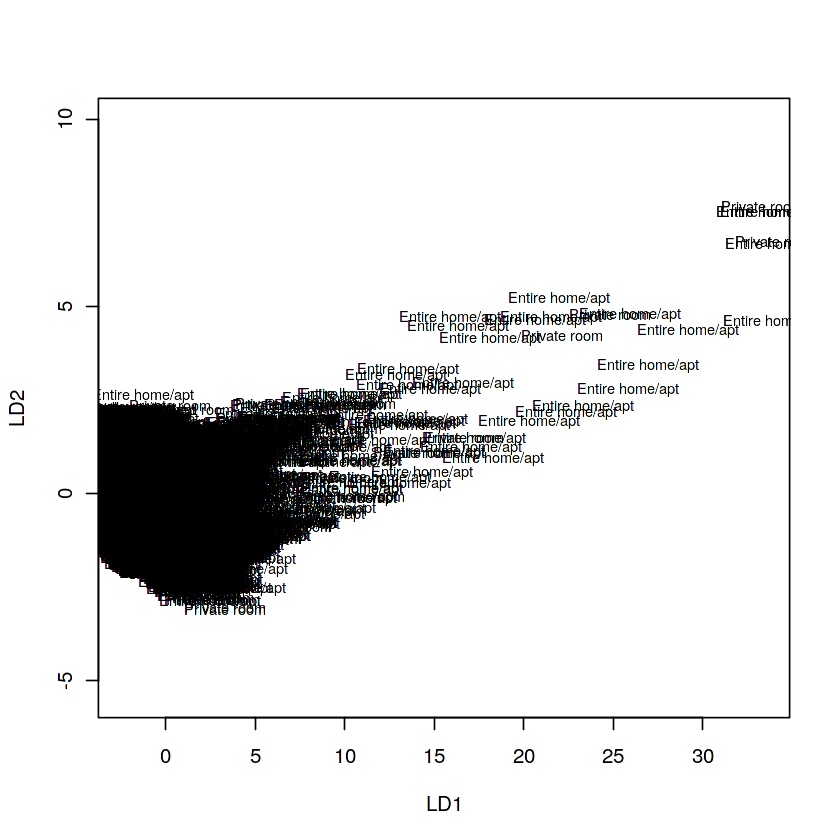

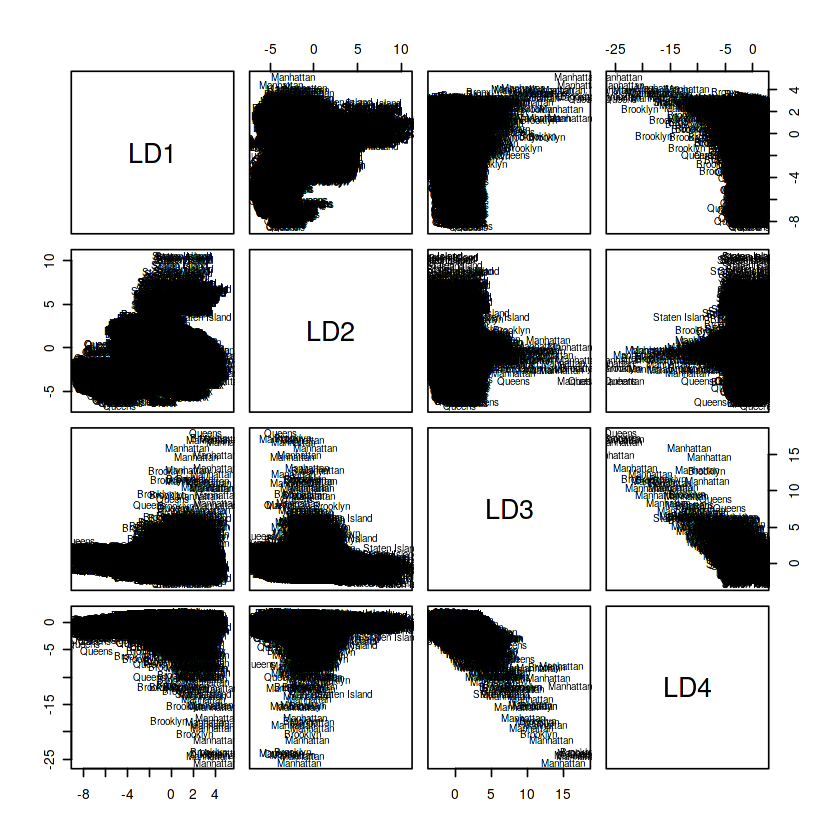

In [8]:
plot(LDA_A)
plot(LDA_B)

In [9]:
#Assesment into Room Type
plot.psych(LDA_A)
#Assesment into neighborhood group
plot.psych(LDA_B)

In [10]:
# Machine Learning ####
fit = lm(AB$latitude ~ AB$availability_365 + AB$longitude + AB$minimum_nights + AB$price, data=AB)
fit2 = lm(AB$longitude ~ AB$availability_365 + AB$longitude + AB$minimum_nights + AB$price, data=AB)
summary(fit)
summary(fit2)

Warning message in model.matrix.default(mt, mf, contrasts):
“the response appeared on the right-hand side and was dropped”
Warning message in model.matrix.default(mt, mf, contrasts):
“problem with term 2 in model.matrix: no columns are assigned”



Call:
lm(formula = AB$latitude ~ AB$availability_365 + AB$longitude + 
    AB$minimum_nights + AB$price, data = AB)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.192432 -0.039619 -0.004075  0.035523  0.179967 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          4.916e+01  4.003e-01 122.802  < 2e-16 ***
AB$availability_365 -1.149e-05  1.899e-06  -6.051 1.45e-09 ***
AB$longitude         1.140e-01  5.414e-03  21.067  < 2e-16 ***
AB$minimum_nights    8.726e-05  1.212e-05   7.199 6.17e-13 ***
AB$price             1.119e-05  1.038e-06  10.782  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05423 on 48890 degrees of freedom
Multiple R-squared:  0.01098,	Adjusted R-squared:  0.0109 
F-statistic: 135.7 on 4 and 48890 DF,  p-value: < 2.2e-16



Call:
lm(formula = AB$longitude ~ AB$availability_365 + AB$longitude + 
    AB$minimum_nights + AB$price, data = AB)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30242 -0.02877 -0.00359  0.01569  0.34930 

Coefficients:
                      Estimate Std. Error    t value Pr(>|t|)    
(Intercept)         -7.395e+01  2.968e-04 -249179.56   <2e-16 ***
AB$availability_365  3.709e-05  1.578e-06      23.51   <2e-16 ***
AB$minimum_nights   -1.606e-04  1.010e-05     -15.90   <2e-16 ***
AB$price            -2.991e-05  8.565e-07     -34.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04531 on 48891 degrees of freedom
Multiple R-squared:  0.03657,	Adjusted R-squared:  0.03651 
F-statistic: 618.6 on 3 and 48891 DF,  p-value: < 2.2e-16


In [11]:
# Machine Learning ####
fit = lm(AB$latitude ~ AB$room_type + AB$longitude + AB$minimum_nights, data=AB)
summary(fit)


Call:
lm(formula = AB$latitude ~ AB$room_type + AB$longitude + AB$minimum_nights, 
    data = AB)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.198040 -0.039714 -0.003733  0.035584  0.179077 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.845e+01  4.015e-01 120.673  < 2e-16 ***
AB$room_typePrivate room -1.050e-03  5.085e-04  -2.065    0.039 *  
AB$room_typeShared room   2.124e-04  1.633e-03   0.130    0.897    
AB$longitude              1.044e-01  5.429e-03  19.237  < 2e-16 ***
AB$minimum_nights         7.899e-05  1.202e-05   6.570  5.1e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05431 on 48890 degrees of freedom
Multiple R-squared:  0.008195,	Adjusted R-squared:  0.008113 
F-statistic:   101 on 4 and 48890 DF,  p-value: < 2.2e-16


In [12]:

fit123 <- kmeans(ABC, centers = 3, nstart = 20)
fit123$centers

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
1,40.72898,-73.95311,125.0177,5.135871,17.878511,1.237563,2.110649,28.07988
2,40.73597,-73.97563,3697.8860,23.771930,4.403509,1.017043,3.078947,189.66667
3,40.72883,-73.95013,183.0980,10.684162,34.149979,1.645813,17.194003,280.88853


Warning message:
“Use of `ABBC$longitude` is discouraged. Use `longitude` instead.”
Warning message:
“Use of `ABBC$price` is discouraged. Use `price` instead.”
Warning message:
“Use of `ABBC$Cluster` is discouraged. Use `Cluster` instead.”
Warning message:
“Use of `ABBC$longitude` is discouraged. Use `longitude` instead.”
Warning message:
“Use of `ABBC$latitude` is discouraged. Use `latitude` instead.”
Warning message:
“Use of `ABBC$Cluster` is discouraged. Use `Cluster` instead.”


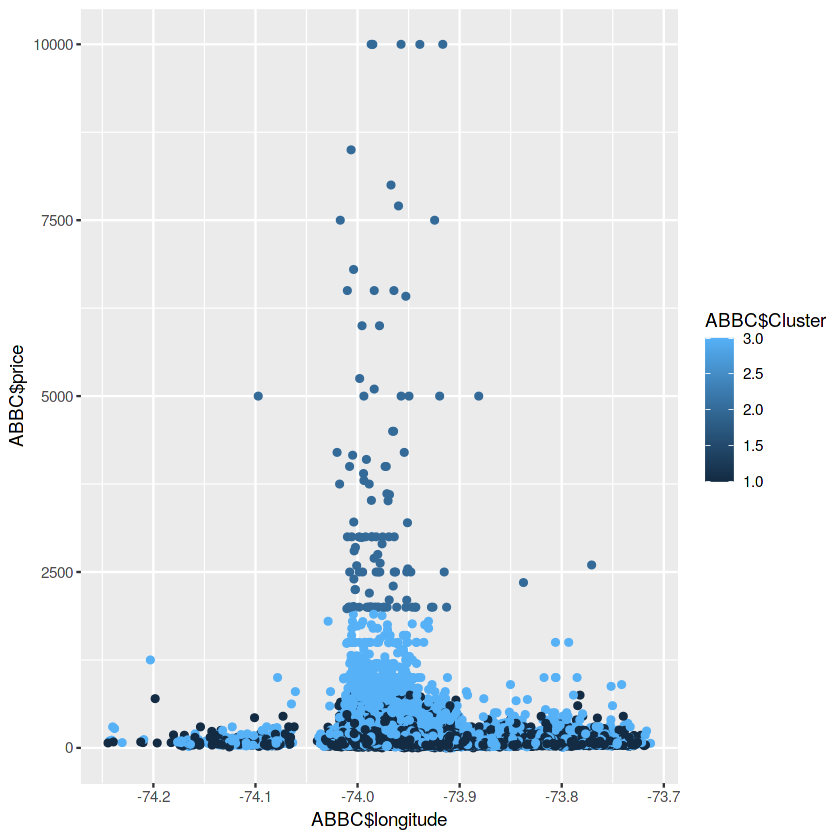

Warning message:
“Use of `ABBC$latitude` is discouraged. Use `latitude` instead.”
Warning message:
“Use of `ABBC$price` is discouraged. Use `price` instead.”
Warning message:
“Use of `ABBC$Cluster` is discouraged. Use `Cluster` instead.”


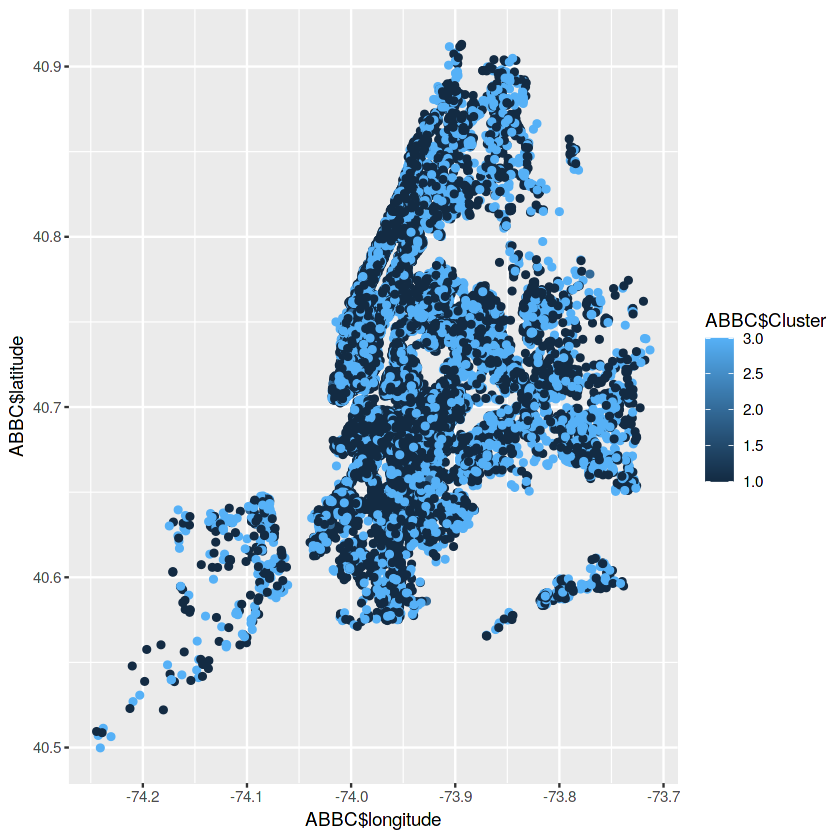

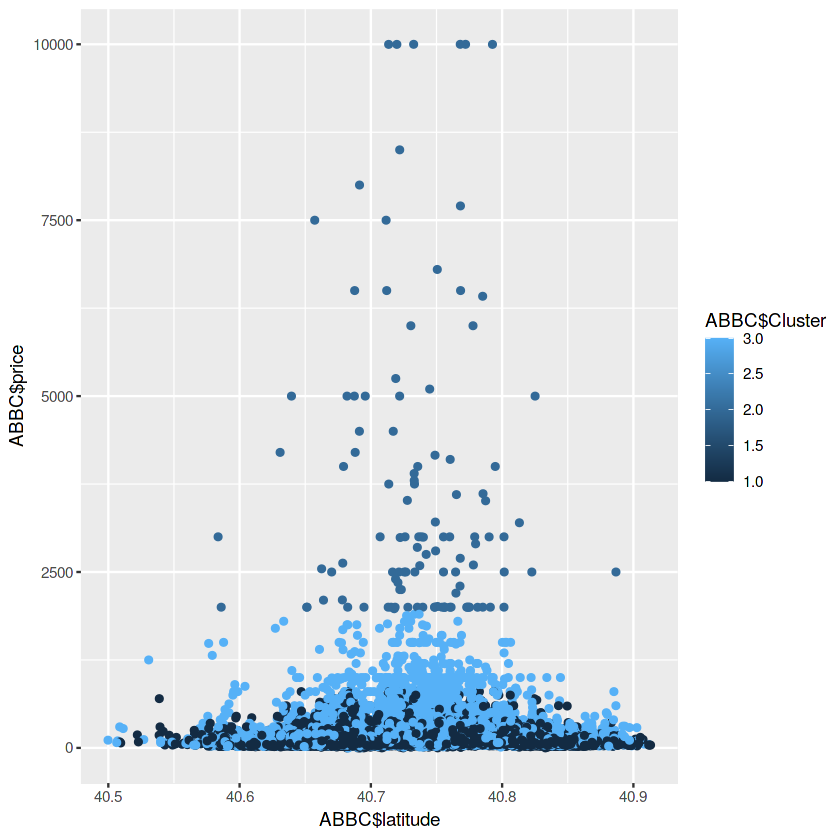

In [13]:
ABBC <- ABC %>%
  mutate(Cluster = fit123$cluster)



ggplot(ABBC, aes(x = ABBC$longitude, y = ABBC$price, 
                 colour = ABBC$Cluster)) + geom_point()


ggplot(ABBC, aes(x = ABBC$longitude, y = ABBC$latitude, 
                 colour = ABBC$Cluster)) + geom_point()

ggplot(ABBC, aes(x = ABBC$latitude, y = ABBC$price, 
                 colour = ABBC$Cluster)) + geom_point()